In [1]:
#...... general imports

import numpy as np
import pickle
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist
import matplotlib.pylab as plt
from tqdm import tqdm

#......new imports (helper class)
import sys
sys.path.insert(0, '../scripts') # adding to the system path
from hlistHelper import hlist # custom object

#...... new MCMC imports
import corner
import emcee
from chainconsumer import ChainConsumer

#...... plot formatting

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}
plt.rc("text", usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams['figure.dpi'] = 100


#...... colors 

custom_blues = ["#99DDFF","#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466", "#000000"]
custom_blues_complement = ["#FFBB99", "#FF9966", "#FF7733", "#FF5500", "#CC4400", "#993300", "#662200","#000000"]
custom_cet_fdm = ["#EE99FF","#E566FF","#DD33FF","#D400FF","#AA00CC","#7F0099"]
#["#fc5eff","#e330ff","#b11eff"]

sim_colors = {}
sim_colors['cdm'] = 'k'
sim_colors['vd100'] = 'm'
sim_colors['wdm_3.5'] = custom_blues_complement[1]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['Tkd_0.72kev'] = 'teal'
sim_colors['Tkd_0.72kev_vd100'] = 'teal'
sim_colors['Tkd_1.46kev'] = 'goldenrod'
sim_colors['Tkd_1.46kev_vd100'] = 'goldenrod'
sim_colors['Tkd_2.32kev'] = 'brown'
sim_colors['Tkd_2.32kev_vd100'] = 'brown'

sim_colors['wdm_3'] = custom_blues_complement[0]
sim_colors['wdm_4'] = custom_blues_complement[1]
sim_colors['wdm_5'] = custom_blues_complement[2]
sim_colors['wdm_6'] = custom_blues_complement[3]
sim_colors['wdm_6.5'] = custom_blues_complement[4]
sim_colors['wdm_10'] = custom_blues_complement[5]
sim_colors['idm_1e-4GeV'] = custom_blues[0]
sim_colors['idm_1e-2GeV'] = custom_blues[2]
sim_colors['idm_1GeV'] = custom_blues[4]
sim_colors['fdm_25.9e-22eV'] = custom_cet_fdm[0]
sim_colors['fdm_69.4e-22eV'] = custom_cet_fdm[1]
sim_colors['fdm_113e-22eV'] = custom_cet_fdm[2]
sim_colors['fdm_151e-22eV'] = custom_cet_fdm[3]
sim_colors['fdm_185e-22eV'] = custom_cet_fdm[4]
sim_colors['fdm_490e-22eV'] = custom_cet_fdm[5]

### shmf data structures

In [11]:
halo_id = 'Halo004'

#...... high level setup, model and redshift lists.
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']
redshifts = np.linspace(0, 4.5, 50)

#...... data storage setup (general)

cdm_shmf_mpeak = {}
wdm_shmf_mpeak = {}

wdm_shmf_mpeak_suppression = {}
wdm_shmf_mpeak_suppression_err = {}

#...... cold dark matter, constant model
cdm = hlist(halo_id=halo_id, model='cdm')
cdm.load_hlists()
cdm.load_hmb()


#..... cycles through all models
for model in models:
    
    #...... warm dark matter, variable mass
    wdm = hlist(halo_id=halo_id, model=model)
    wdm.load_hlists()
    wdm.load_hmb()

    cdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak[model] = {}
    wdm_shmf_mpeak_suppression[model] = {}
    wdm_shmf_mpeak_suppression_err[model] = {}
    
    #...... cycles through redshifts up to z = 4.5
    for z in tqdm(redshifts):

        #...... data storage setup (based on redshift)

        cdm_shmf_mpeak[model][f'{z}'] = {}
        cdm_shmf_mpeak[model][f'{z}']['phi'] = []
        cdm_shmf_mpeak[model][f'{z}']['N'] = []

        wdm_shmf_mpeak[model][f'{z}'] = {}
        wdm_shmf_mpeak[model][f'{z}']['phi'] = []
        wdm_shmf_mpeak[model][f'{z}']['N'] = []

        # getting halos for given redshift
        halos, subhalos = cdm.get_z(z)
        halos_wdm, subhalos_wdm = wdm.get_z(z)

        # distances of isolated halo pop from host halo
        distances = np.sqrt((halos['x']-cdm.hmb['x'][0])**2+(halos['y']-cdm.hmb['y'][0])**2+(halos['z']-cdm.hmb['z'][0])**2)
        
        # mass and distance cut; 900e5 Msun/h, 3 Mpc
        ind_cdm = (halos['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)

        # getting shmf
        cdm_temp = get_shmf(halos['Mpeak'][ind_cdm]/h,base_mpeak)
        cdm_shmf_mpeak[model][f'{z}']['phi'].append(cdm_temp[0]) # shmf, N/N_cdm for discrete mass
        cdm_shmf_mpeak[model][f'{z}']['N'].append(cdm_temp[1]) # shmf, values

        #...... same process, warm dark matter
        distances = np.sqrt((halos_wdm['x']-wdm.hmb['x'][0])**2+(halos_wdm['y']-wdm.hmb['y'][0])**2+(halos_wdm['z']-wdm.hmb['z'][0])**2)
        ind = (halos_wdm['Mvir']/h > m_part/h*lower_limit) & (distances/h < 3.)
        wdm_temp = get_shmf(halos_wdm['Mpeak'][ind]/h,base_mpeak)
        wdm_shmf_mpeak[model][f'{z}']['phi'].append(wdm_temp[0])
        wdm_shmf_mpeak[model][f'{z}']['N'].append(wdm_temp[1])

        # poisson error on the mean; when combining different realizations, 

        yerr_lower = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        yerr_upper = (1./(np.sqrt(np.mean(wdm_shmf_mpeak[model][f'{z}']['N'],axis=0))))*np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)

        #...... saving suppresion and error

        wdm_shmf_mpeak_suppression[model][f'{z}'] = np.mean(wdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)/np.mean(cdm_shmf_mpeak[model][f'{z}']['phi'],axis=0)
        wdm_shmf_mpeak_suppression_err[model][f'{z}'] = np.amax(np.vstack((yerr_lower,yerr_upper)),axis=0)


100%|██████████| 50/50 [02:15<00:00,  2.71s/it]


### existing functions (week 4)

In [12]:
h = 0.7 #H0 in units of 100 km/s/Mpc
m_part = 3e5 #particle mass, Msun/h

#...... particle limits?
lower_limit=300 
upper_limit=1.3e4 # why do we set this uppper limit here?

bin_number=10
base_mpeak = np.logspace(np.log10(m_part/h*lower_limit),np.log10(m_part/h*upper_limit),bin_number)

def get_shmf(masses,bins):
    values_mpeak, base_mpeak = np.histogram(masses,bins)
    return values_mpeak/(base_mpeak[1:]-base_mpeak[0:-1]), values_mpeak, base_mpeak

In [13]:
def transfer(k, mwdm, a = 0.0292, b = -1.188, nu = 1.049, theta = 2.012, eta = 0.2463, omega_m=0.286, h=0.7):
    alpha = a*(mwdm**b)*((omega_m*h*h/0.12)**eta)*((h/0.6736)**theta)
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

def khm(mwdm, k_array=np.logspace(0,3,1000), h=0.7):
    return k_array[np.argmin(np.abs(transfer(k_array,mwdm)**2-0.25))]*h

def Mhm(mwdm, omega_m = 0.286, h=0.7):
    rho_m = 1.36*10**11*omega_m
    return (4.*np.pi*rho_m/3.)*((2.*np.pi/(khm(mwdm)*h))/2.)**3.

def shmf_suppression(M,mwdm,alpha=2.7,beta=1.,gamma=0.99):
    return (1.+(alpha*(Mhm(mwdm))/(M))**beta)**(-1.*gamma)

In [32]:
def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, model='wdm_3', z = 0.0):
    alpha, beta, gamma = theta
    lnlike = 0.
    mass = float(model[4:]) 
    
    shmf_model = (1.+(alpha*Mhm(mass)/x)**beta)**(-1.*gamma)
    lnlike += -0.5*np.sum((y[model][f'{z}']-shmf_model)**2/yerr[model][f'{z}']**2 + np.log(yerr[model][f'{z}']**2))
    return lnlike

def log_prior(theta):
    alpha, beta, gamma = theta
    if 0. < gamma < 5. and 0. < alpha < 50. and 0. < beta < 10.:
        return np.log(1.0/(1.0+(beta**2))) + np.log(1.0/(1.0+(gamma**2)))
    return -np.inf

def log_probability(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, model='wdm_3', z = 0.0):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model, z)

In [50]:
z_desired = 2.5
redshifts = np.linspace(0, 4.5, 50)


x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = wdm_shmf_mpeak_suppression
yerr = wdm_shmf_mpeak_suppression_err
model = 'wdm_3'
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, model, z))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [03:12<00:00, 52.06it/s]


best fit values:
[2.65356038 0.44037257 0.89081321]


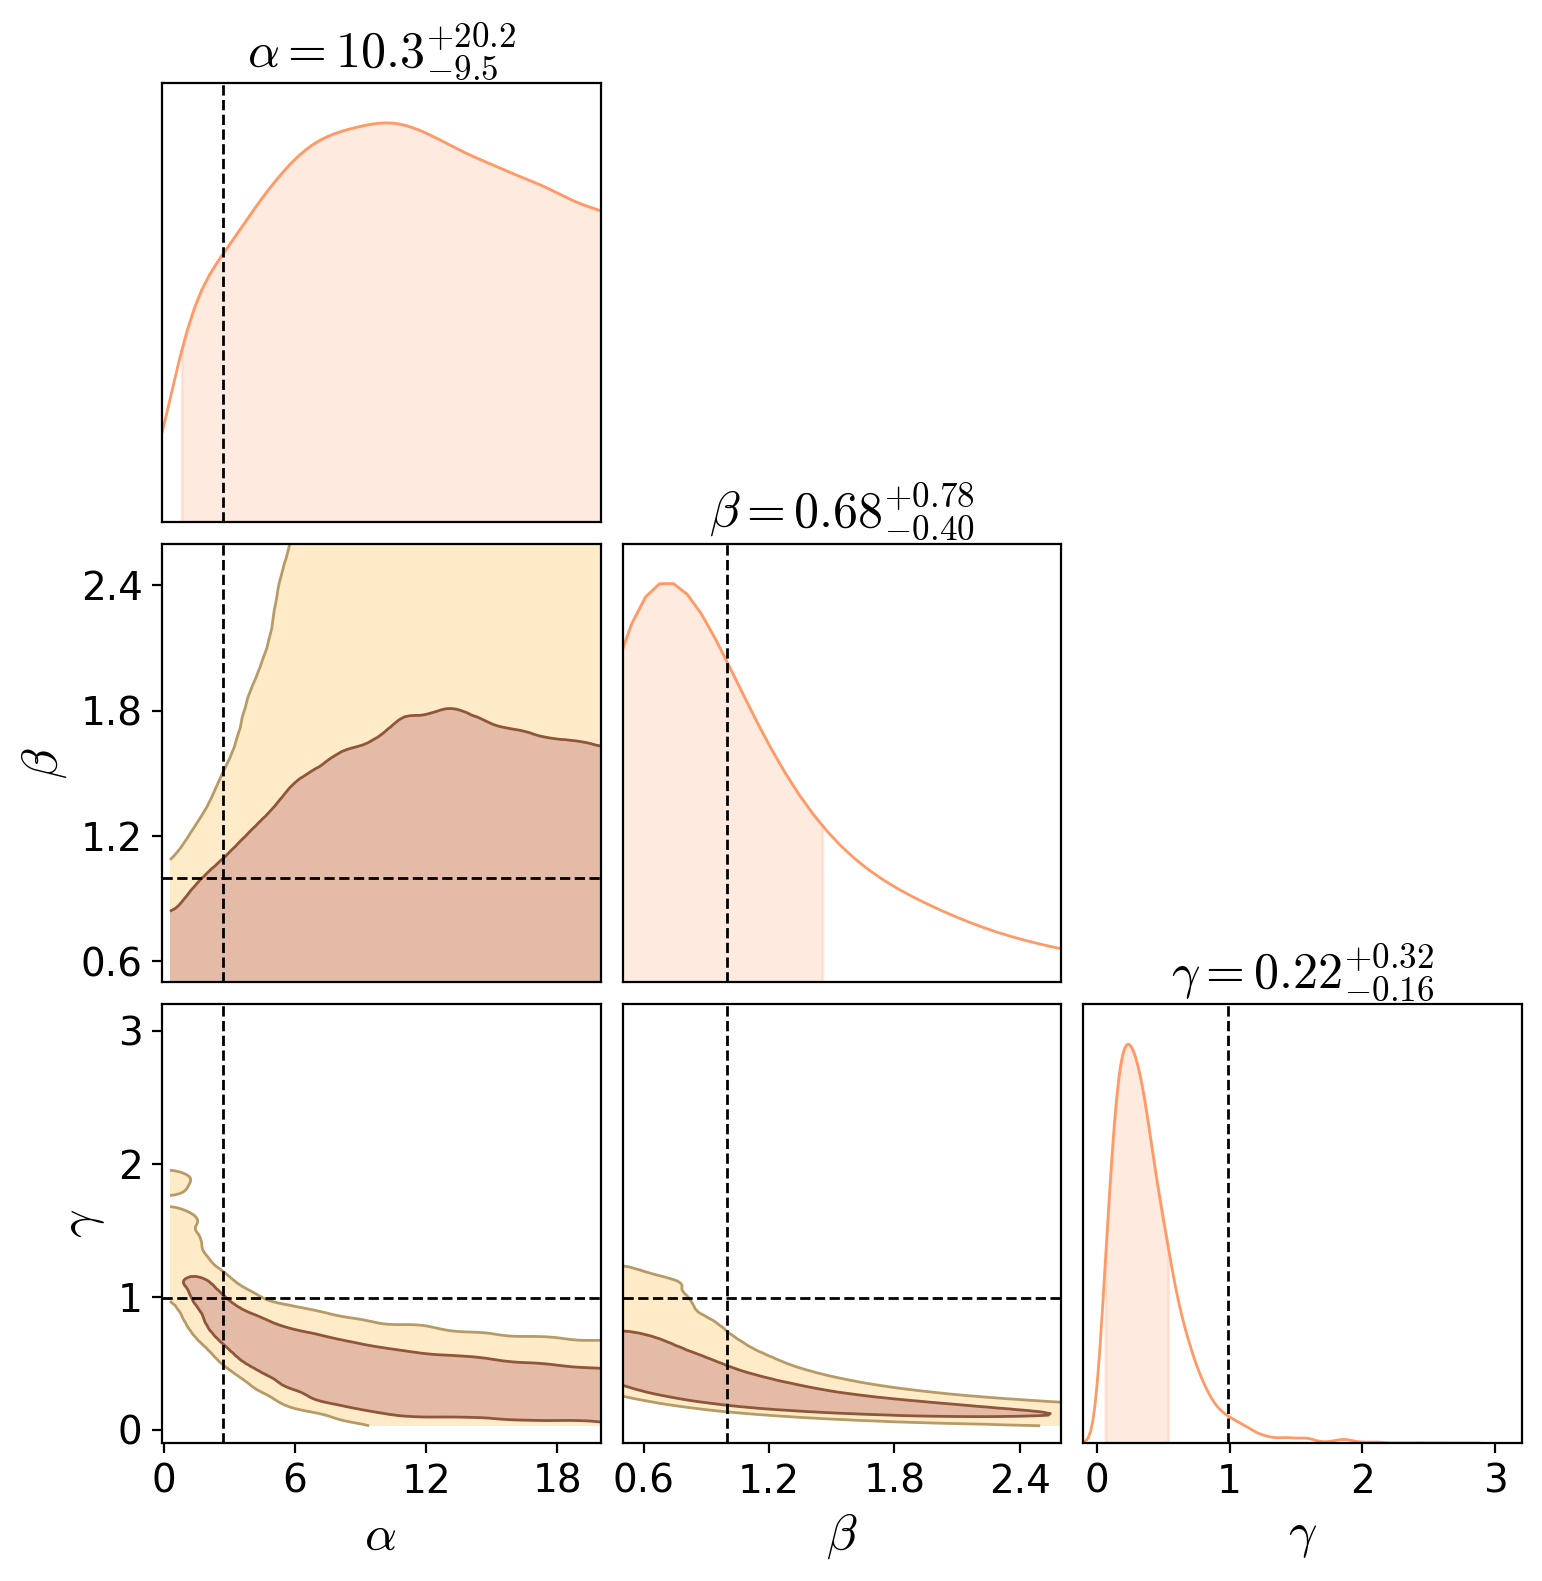

In [51]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

c.configure(colors=[sim_colors['wdm_4'], sim_colors['wdm_5']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

### combined realizations

In [66]:
z_desired = 0

redshifts = np.linspace(0, 4.5, 50)
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])
models = ['wdm_3', 'wdm_4', 'wdm_5','wdm_6','wdm_6.5', 'wdm_10']

combined_model = []
combined_model_err = []

for model in models:
    
    combined_model.append(wdm_shmf_mpeak_suppression[model][f'{z}'])
    combined_model_err.append(wdm_shmf_mpeak_suppression_err[model][f'{z}'])
    
    
combined_model = np.asarray(combined_model)
combined_model_err = np.asarray(combined_model_err)

In [67]:
def log_likelihood(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    alpha, beta, gamma = theta
    lnlike = 0.
    mass = np.asarray([3.,4.,5.,6.,6.5,10.])
    
    shmf_model = []
    for mwdm in mass:
        shmf_model.append((1.+(alpha*Mhm(mwdm)/x)**beta)**(-1.*gamma))
        
    shmf_model = np.asarray(shmf_model) 
    lnlike += -0.5*np.sum((y-shmf_model)**2/yerr**2 + np.log(yerr**2))
    return lnlike

def log_probability(theta, x=0.5*(base_mpeak[1:]+base_mpeak[:-1]), y = wdm_shmf_mpeak_suppression, yerr = wdm_shmf_mpeak_suppression_err, z = 0.0):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, z)

In [68]:
x = 0.5*(base_mpeak[1:]+base_mpeak[:-1])
y = combined_model
yerr = combined_model_err
z = str(redshifts[np.argmin(np.abs(redshifts - z_desired))])


x0=np.array([2.7, 1., 0.99])

pos = x0 + 1e-2 * np.random.randn(100, 3) # posterior function?
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr, z))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [16:57<00:00,  9.82it/s]


best fit values:
[1.49667633 0.8143938  1.27636474]


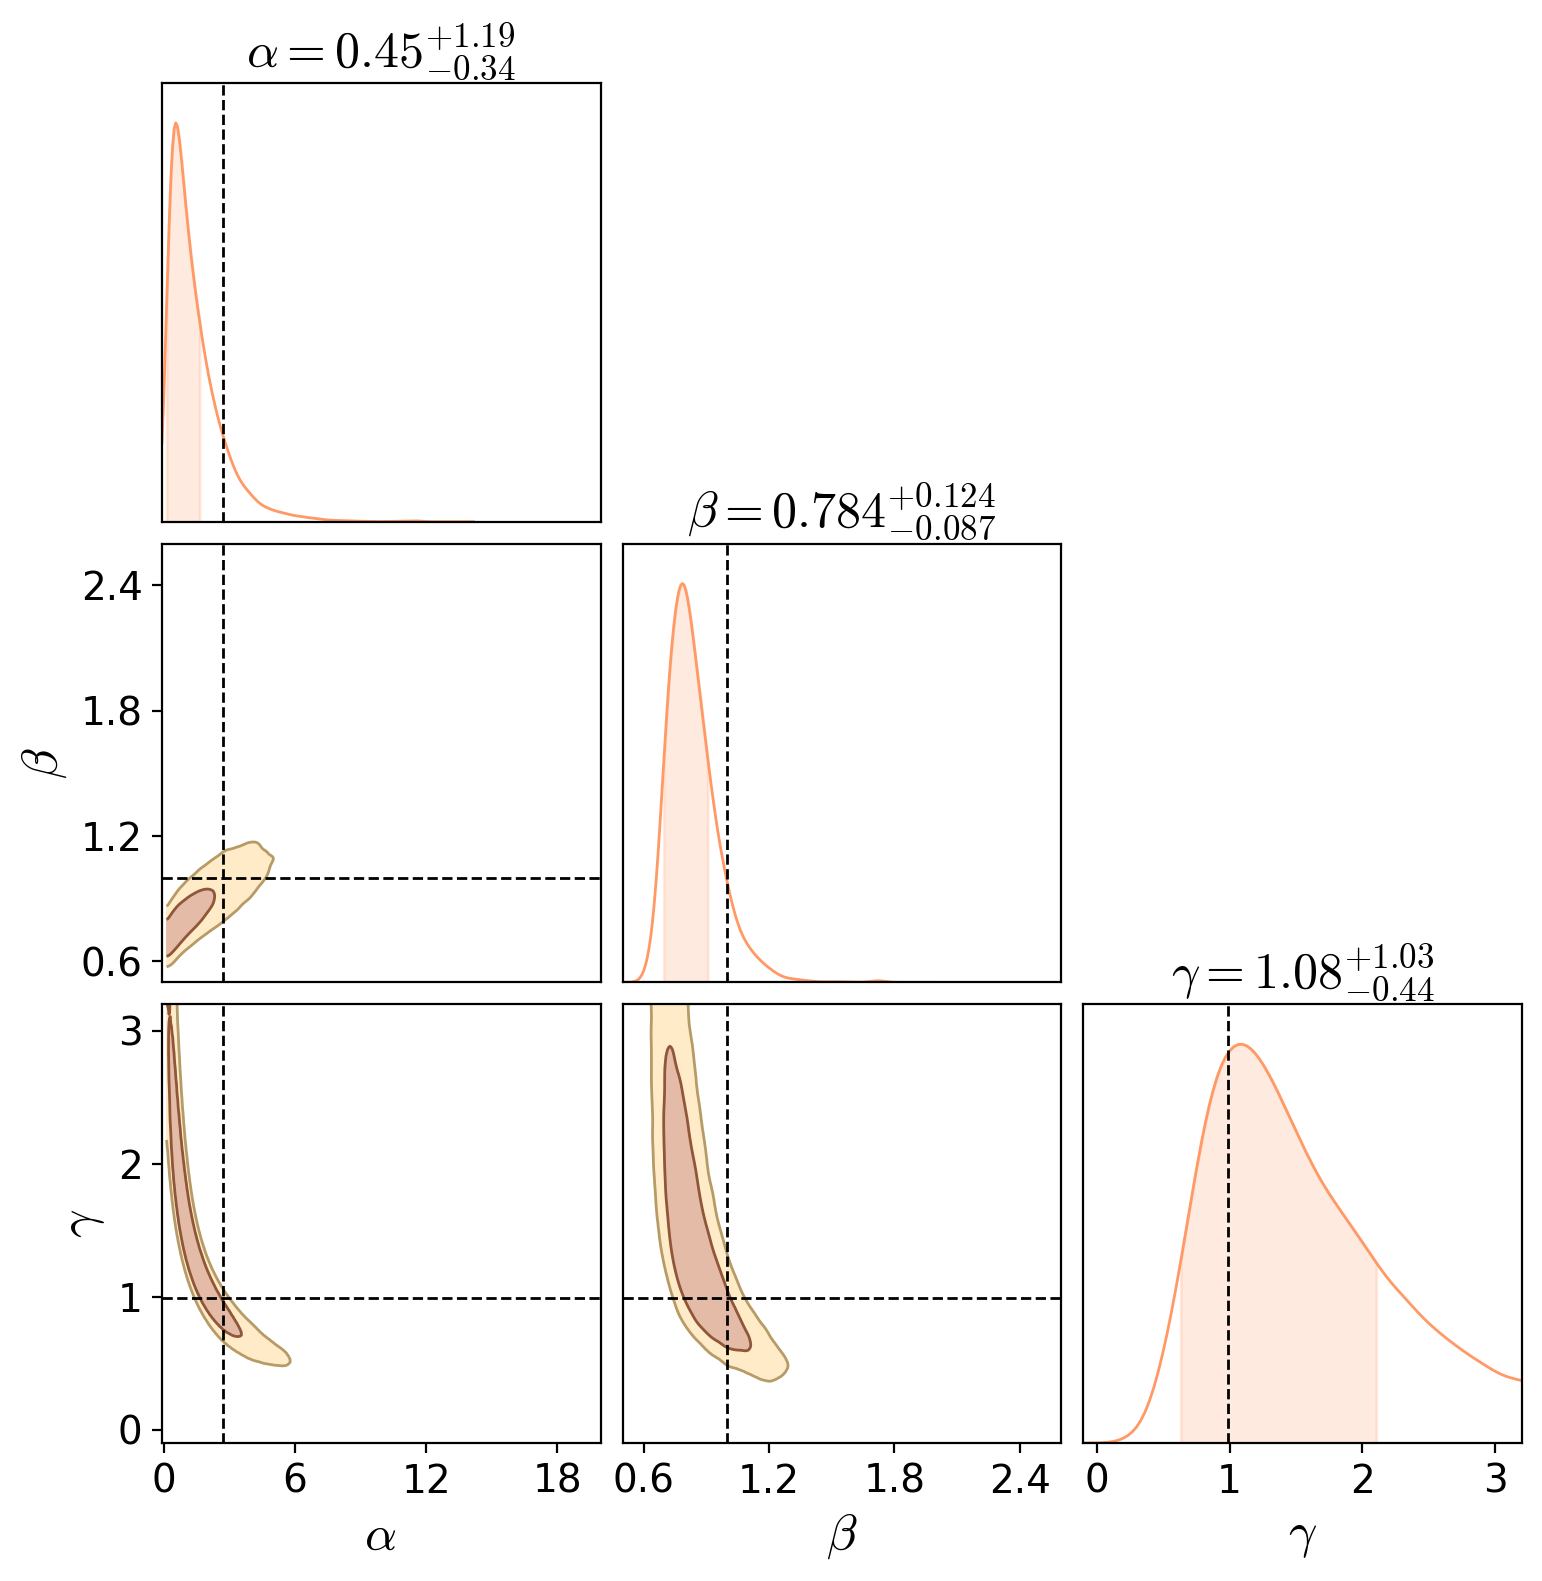

In [69]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
print('best fit values:')
print(flat_samples[np.argmax(sampler.get_log_prob(discard=1000, flat=True).shape)])

labels = [r"$\alpha$", r"$\beta$", r"$\gamma$"]

c = ChainConsumer()
c.add_chain(flat_samples, parameters=[r"$\alpha$", r"$\beta$", r"$\gamma$"])

c.configure(colors=[sim_colors['wdm_4'], sim_colors['wdm_5']], shade=[True,False], shade_alpha=0.5, bar_shade=True,spacing=1.0,
                diagonal_tick_labels=False, tick_font_size=14, label_font_size=18, sigma2d=False,max_ticks=4, 
                summary=True,kde=False)
fig = c.plotter.plot(figsize=(8,8), extents=[[-0.1,20],[0.5,2.6],[-0.1,3.2]], truth=[2.7,1.,0.99],display=True)

In [70]:
alpha = 2.7
beta = 0.99
gamma = 1.

mass = np.asarray([3.,4.,5.,6.,6.5,10.])
    
shmf_model = []
for mwdm in mass:
    shmf_model.append((1.+(alpha*Mhm(mwdm)/x)**beta)**(-1.*gamma))

shmf_model = np.asarray(shmf_model)
    
shmf_model

array([[0.12473747, 0.17744843, 0.24616904, 0.33080017, 0.4280071 ,
        0.53110842, 0.63162073, 0.72187021, 0.79711165],
       [0.2846556 , 0.3759199 , 0.47693608, 0.57987499, 0.67630483,
        0.75977076, 0.82721328, 0.87874362, 0.91645805],
       [0.4647848 , 0.56794876, 0.66553711, 0.75075629, 0.82013042,
        0.87344993, 0.91264719, 0.94053023, 0.95990401],
       [0.62141046, 0.71302486, 0.78996295, 0.85059604, 0.89602939,
        0.92880303, 0.95180147, 0.96762974, 0.97837813],
       [0.68633735, 0.76810338, 0.83371856, 0.88358186, 0.91992857,
        0.94562586, 0.96340421, 0.97552017, 0.98369273],
       [0.90910515, 0.93804205, 0.95819039, 0.97198231, 0.98131336,
        0.98757651, 0.99175808, 0.99453998, 0.99638632]])

In [71]:
y

array([[0.125     , 0.24166667, 0.39506173, 0.39240506, 0.73333333,
        0.41025641, 0.875     , 0.66666667, 0.78571429],
       [0.40625   , 0.46666667, 0.59259259, 0.48101266, 0.86666667,
        0.82051282, 0.8125    , 0.88888889, 0.78571429],
       [0.6       , 0.63333333, 0.62962963, 0.70886076, 1.04444444,
        0.69230769, 1.1875    , 0.83333333, 1.        ],
       [0.66875   , 0.8       , 0.75308642, 0.81012658, 1.02222222,
        0.76923077, 1.        , 0.88888889, 1.07142857],
       [0.71875   , 0.85      , 0.75308642, 0.91139241, 0.95555556,
        0.76923077, 1.0625    , 0.88888889, 1.07142857],
       [0.9       , 0.95      , 0.88888889, 0.96202532, 0.88888889,
        0.94871795, 1.        , 0.88888889, 1.14285714]])

In [72]:
y - shmf_model

array([[ 2.62527102e-04,  6.42182329e-02,  1.48892686e-01,
         6.16048953e-02,  3.05326237e-01, -1.20852014e-01,
         2.43379271e-01, -5.52035476e-02, -1.13973664e-02],
       [ 1.21594399e-01,  9.07467663e-02,  1.15656513e-01,
        -9.88623329e-02,  1.90361834e-01,  6.07420616e-02,
        -1.47132797e-02,  1.01452736e-02, -1.30743767e-01],
       [ 1.35215204e-01,  6.53845723e-02, -3.59074772e-02,
        -4.18955265e-02,  2.24314027e-01, -1.81142238e-01,
         2.74852807e-01, -1.07196895e-01,  4.00959854e-02],
       [ 4.73395353e-02,  8.69751435e-02, -3.68765325e-02,
        -4.04694582e-02,  1.26192828e-01, -1.59572261e-01,
         4.81985339e-02, -7.87408477e-02,  9.30504454e-02],
       [ 3.24126520e-02,  8.18966219e-02, -8.06321373e-02,
         2.78105499e-02,  3.56269817e-02, -1.76395095e-01,
         9.90957905e-02, -8.66312801e-02,  8.77358389e-02],
       [-9.10514648e-03,  1.19579519e-02, -6.93015001e-02,
        -9.95699852e-03, -9.24244733e-02, -3.885855